![Banner](https://github.com/LittleHouse75/flatiron-resources/raw/main/NevitsBanner.png)

----

# External Evaluation: DFPI Scam Wallets

----

## Overview (BLUF)

**Bottom line:** A model trained on our stitched Ethereum dataset still performs strongly on a **real-world set of scam wallets reported by the California DFPI**, reaching ROC AUC ≈ 0.97 and AP ≈ 0.90, and flagging most DFPI scam addresses with very few false positives.

In the earlier notebooks we answered:

- **Random split:** How well can we separate scam vs non-scam addresses when train and test come from the *same* distribution?
- **Time split:** What happens when we train on the past and test on the future, with real **time drift**?

This notebook adds a third view:

> **If we train on our original dataset and then move to a totally separate, regulator-driven dataset,  
> do the learned behavioral patterns still pick out real scam wallets?**

At a high level we:

- Build a **DFPI external dataset** from California’s public crypto scam tracker (Ethereum scam wallets only) plus **on-chain history from Etherscan**.
- Engineer the **same address-level features** we used in the random/time-split experiments.
- Apply the **final tuned XGBoost random-split model** *without retraining* and measure performance.

If the model still highlights DFPI scam wallets with high precision and good recall, that’s evidence it has learned **portable fraud signals**, not just quirks of the original training slice.

## 1. DFPI External Dataset — What It Is (and Isn’t)

To build a real-world test set, we started from the **California Department of Financial Protection and Innovation (DFPI)** crypto scam tracker:

- DFPI publishes public notices describing **fraudulent trading platforms, pig-butchering scams, and other schemes**.
- Many of these notices include one or more **Ethereum wallet addresses** that victims sent funds to.

From those pages, we constructed the DFPI external dataset in three steps:

1. **Scrape DFPI scam pages** and extract every Ethereum address mentioned.
2. For each address, use the **Etherscan API** to pull its recent transaction history (this scrape is mostly **late 2024**).
3. Build a transaction table where either `from` or `to` is one of these DFPI wallets, then aggregate to **address-level features** using the *same feature engineering pipeline* as the main experiments.

Address labels in this notebook are:

- **Scam = 1:** Address appears on the DFPI list (explicitly named in a complaint / enforcement notice).
- **Scam = 0:** Address appears in those same transactions (as a counterparty / neighbor) but **does not** appear on the DFPI list. We sample a limited number of these negatives to keep the dataset manageable.

So every address here is either:

- A **regulator-flagged scam wallet**, or  
- A **local neighbor** that has transacted with at least one DFPI scam wallet.

### What this dataset is *not*

It’s important to be clear about limitations:

- This is **not** a random sample of all Ethereum activity.
- Negatives are **“not on DFPI’s list”**, not “provably clean”:
  - Many are likely **victims or intermediaries**, and some could be undiscovered scams.
- We only see the portion of history exposed by our Etherscan queries, not full lifetime histories.

Because of that, we treat DFPI as a **pure external evaluation set**, not as extra training data.  
The question here is strictly:

> *Given a model trained elsewhere, does it still score real DFPI scam wallets as high-risk in the wild?*

## 2. Notebook Setup & DFPI Raw Load

This section mirrors the earlier experiments:

- Set up imports and project paths (so we can reuse `src.utilities` and `src.featureeng`).
- Load the **DFPI transaction scrape** from disk.
- Normalize timestamps and fix dtypes so feature engineering can plug in cleanly.

The idea is to reuse the **same pipeline** as the core notebooks, just pointed at a different slice of Ethereum.

In [1]:
# Enable autoreload so edits to src/*.py modules are picked up without restarting the kernel
%load_ext autoreload
%autoreload 2

import sys
import os
import io
import joblib
sys.path.append(os.path.abspath(".."))

import pandas as pd
from pathlib import Path
from typing import Final
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

# Project-specific utilities and feature engineering
import src.utilities as util
from src.featureeng import normalize_timestamps, engineer_address_features

# Consistent plotting style
sns.set_style("whitegrid")

# ------------------------------------------------------------
# Resolve project root and key DFPI paths
# ------------------------------------------------------------
PROJECT_ROOT: Final[Path] = Path(util.__file__).resolve().parents[1]
print("PROJECT_ROOT:", PROJECT_ROOT)

TX_PATH = PROJECT_ROOT / "data" / "external" / "dfpi_all_txs.csv"
SCAM_PATH = PROJECT_ROOT / "data" / "external" / "dfpi_eth_scams.txt"

print("TX_PATH:", TX_PATH)

# ------------------------------------------------------------
# Load DFPI transaction scrape and align schema to main pipeline
# ------------------------------------------------------------
df = pd.read_csv(TX_PATH)

# Align column names with the main Ethereum schema
df = df.rename(columns={
    "from": "from_address",
    "to": "to_address",
    "value": "value",
    "gasPrice": "gas_price",
})

# Parse Unix timestamps into a proper datetime column
df["block_timestamp"] = pd.to_datetime(df["timeStamp"], unit="s", utc=True)

# Normalize timestamps + add derived features (hour, weekday, etc.)
df = normalize_timestamps(df, ts_col="block_timestamp", verbose=True)

# Ensure core numeric fields have numeric dtypes
for col in ["blockNumber", "value", "gas", "gas_price", "gasUsed", "confirmations"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# Clean up isError flag
df["isError"] = pd.to_numeric(df["isError"], errors="coerce").fillna(0).astype(int)

df.head()

PROJECT_ROOT: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum
TX_PATH: /Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/data/external/dfpi_all_txs.csv

----------------------------------------
Timestamp normalization
----------------------------------------

Converting `block_timestamp` into a consistent UTC datetime and adding derived features (hour, weekday).
Value types in timestamp column:
block_timestamp
<class 'pandas._libs.tslibs.timestamps.Timestamp'>    8106
Name: count, dtype: int64
Number of missing raw timestamp values: 0
Parsed timestamps (non-null): 8106
Unparseable timestamps: 0


,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from_address,to_address,value,gas,...,confirmations,methodId,functionName,dfpi_scam_address,block_timestamp,block_timestamp_raw,block_timestamp_std,block_timestamp_dt,hour,weekday
0,21189747,1731633335,0x09feaba97d3a29d8d0ee2ceab33715446505b004f5c6...,9818743,0x81cd7aaa897f51ffa565997d346e189aeefaf5e66f39...,159,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0x0f16e4832aecdb8f207502f6c94455541dd995e7,1.388177e+19,21000,...,2671692,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-15 01:15:35+00:00,2024-11-15 01:15:35+00:00,2024-11-15 01:15:35,2024-11-15 01:15:35+00:00,1,Friday
1,21190246,1731639335,0xf664de1e45d8e1e0e8d922b5ece1f8ac864bd0816e6b...,0,0x7233f71c26e426abf3a8c9b929a1df12dc1517267446...,169,0xd17346e34abaff4539cc7c2893e1bb8dceba6d36,0x0f16e4832aecdb8f207502f6c94455541dd995e7,4.370685e+16,21000,...,2671193,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-15 02:55:35+00:00,2024-11-15 02:55:35+00:00,2024-11-15 02:55:35,2024-11-15 02:55:35+00:00,2,Friday
2,21204570,1731812027,0xdda3e21b6388200db631b548eb4855dfb44a4ba4a4bc...,0,0x901467bbbd700c5f138970409e14fc48b01cc3b64829...,133,0x0f16e4832aecdb8f207502f6c94455541dd995e7,0xf65b1151cc0162665d32c1611b6ad0d8c92c2d45,1.350000e+19,21000,...,2656869,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-17 02:53:47+00:00,2024-11-17 02:53:47+00:00,2024-11-17 02:53:47,2024-11-17 02:53:47+00:00,2,Sunday
3,21251761,1732380815,0x47264bbe81b0c48405f80143f99ee5effa96499d1eb3...,1462604,0xa934ed2900ab26d071d3194fd26b4f50b9e276081b03...,206,0xcfc0f98f30742b6d880f90155d4ebb885e55ab33,0x0f16e4832aecdb8f207502f6c94455541dd995e7,2.865230e+17,21000,...,2609678,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-23 16:53:35+00:00,2024-11-23 16:53:35+00:00,2024-11-23 16:53:35,2024-11-23 16:53:35+00:00,16,Saturday
4,21285399,1732787243,0xbc7de43976a215137717e4e3818442394303816c310c...,1,0x933eb0f4b2315a49ba71ad5a82f84e177aeb51490054...,136,0x0f16e4832aecdb8f207502f6c94455541dd995e7,0xdac17f958d2ee523a2206206994597c13d831ec7,0.000000e+00,70000,...,2576040,0xa9059cbb,"transfer(address _to, uint256 _value)",0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-28 09:47:23+00:00,2024-11-28 09:47:23+00:00,2024-11-28 09:47:23,2024-11-28 09:47:23+00:00,9,Thursday


## 3. DFPI Raw Transaction Snapshot

Before we jump to address-level features, we do a quick health check on the  **DFPI transaction scrape**:

- Confirm shape, dtypes, and obvious missingness
- Visually inspect a few rows to make sure the Etherscan → CSV → notebook path is sane

This mirrors the light-touch raw overview from the main EDA notebook, just on the much smaller DFPI slice.

In [2]:
util.print_heading("DFPI External Dataset — Raw Transaction Overview")

util.print_sub_heading("Shape and basic info")
print(f"Rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")

buf = io.StringIO()
df.info(buf=buf)
print(buf.getvalue())

util.print_sub_heading("First 5 rows")
display(df.head())

util.print_sub_heading("Null value counts (per column)")
display(df.isnull().sum())


DFPI External Dataset — Raw Transaction Overview


----------------------------------------
Shape and basic info
----------------------------------------

Rows: 8,106
Columns: 27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8106 entries, 0 to 8105
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   blockNumber          8106 non-null   int64              
 1   timeStamp            8106 non-null   int64              
 2   hash                 8106 non-null   object             
 3   nonce                8106 non-null   int64              
 4   blockHash            8106 non-null   object             
 5   transactionIndex     8106 non-null   int64              
 6   from_address         8106 non-null   object             
 7   to_address           8105 non-null   object             
 8   value                8106 non-null   float64            
 9   gas                  8106 

,blockNumber,timeStamp,hash,nonce,blockHash,transactionIndex,from_address,to_address,value,gas,...,confirmations,methodId,functionName,dfpi_scam_address,block_timestamp,block_timestamp_raw,block_timestamp_std,block_timestamp_dt,hour,weekday
0,21189747,1731633335,0x09feaba97d3a29d8d0ee2ceab33715446505b004f5c6...,9818743,0x81cd7aaa897f51ffa565997d346e189aeefaf5e66f39...,159,0xb5d85cbf7cb3ee0d56b3bb207d5fc4b82f43f511,0x0f16e4832aecdb8f207502f6c94455541dd995e7,1.388177e+19,21000,...,2671692,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-15 01:15:35+00:00,2024-11-15 01:15:35+00:00,2024-11-15 01:15:35,2024-11-15 01:15:35+00:00,1,Friday
1,21190246,1731639335,0xf664de1e45d8e1e0e8d922b5ece1f8ac864bd0816e6b...,0,0x7233f71c26e426abf3a8c9b929a1df12dc1517267446...,169,0xd17346e34abaff4539cc7c2893e1bb8dceba6d36,0x0f16e4832aecdb8f207502f6c94455541dd995e7,4.370685e+16,21000,...,2671193,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-15 02:55:35+00:00,2024-11-15 02:55:35+00:00,2024-11-15 02:55:35,2024-11-15 02:55:35+00:00,2,Friday
2,21204570,1731812027,0xdda3e21b6388200db631b548eb4855dfb44a4ba4a4bc...,0,0x901467bbbd700c5f138970409e14fc48b01cc3b64829...,133,0x0f16e4832aecdb8f207502f6c94455541dd995e7,0xf65b1151cc0162665d32c1611b6ad0d8c92c2d45,1.350000e+19,21000,...,2656869,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-17 02:53:47+00:00,2024-11-17 02:53:47+00:00,2024-11-17 02:53:47,2024-11-17 02:53:47+00:00,2,Sunday
3,21251761,1732380815,0x47264bbe81b0c48405f80143f99ee5effa96499d1eb3...,1462604,0xa934ed2900ab26d071d3194fd26b4f50b9e276081b03...,206,0xcfc0f98f30742b6d880f90155d4ebb885e55ab33,0x0f16e4832aecdb8f207502f6c94455541dd995e7,2.865230e+17,21000,...,2609678,0x,NaN,0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-23 16:53:35+00:00,2024-11-23 16:53:35+00:00,2024-11-23 16:53:35,2024-11-23 16:53:35+00:00,16,Saturday
4,21285399,1732787243,0xbc7de43976a215137717e4e3818442394303816c310c...,1,0x933eb0f4b2315a49ba71ad5a82f84e177aeb51490054...,136,0x0f16e4832aecdb8f207502f6c94455541dd995e7,0xdac17f958d2ee523a2206206994597c13d831ec7,0.000000e+00,70000,...,2576040,0xa9059cbb,"transfer(address _to, uint256 _value)",0x0F16E4832AEcDb8f207502F6C94455541Dd995e7,2024-11-28 09:47:23+00:00,2024-11-28 09:47:23+00:00,2024-11-28 09:47:23,2024-11-28 09:47:23+00:00,9,Thursday



----------------------------------------
Null value counts (per column)
----------------------------------------



blockNumber               0
timeStamp                 0
hash                      0
nonce                     0
blockHash                 0
transactionIndex          0
from_address              0
to_address                1
value                     0
gas                       0
gas_price                 0
isError                   0
txreceipt_status          0
input                     0
contractAddress        8105
cumulativeGasUsed         0
gasUsed                   0
confirmations             0
methodId                  0
functionName           4206
dfpi_scam_address         0
block_timestamp           0
block_timestamp_raw       0
block_timestamp_std       0
block_timestamp_dt        0
hour                      0
weekday                   0
dtype: int64

## 4. DFPI Wallet Labels & Sampling

Here we connect the **raw DFPI scrape** to our modeling definitions:

- Load the list of **DFPI-reported scam wallets** (positives).
- Identify **all addresses** that appear in the DFPI transactions.
- Define **candidate negatives** as non-DFPI addresses that transacted with those scams  
  (counterparties and neighbors, not “random clean Ethereum”).
- Sample a limited number of negatives so the external set is compact but non-trivial.

We also sanity-check **time coverage** for the DFPI scrape:

- What calendar window does it span?
- How many transactions per day do we actually see?


DFPI Wallet Labels — Positives and Candidate Negatives

DFPI scam wallet count (file): 59
Unique addresses seen in DFPI txs: 1,962
Candidate negatives (non-DFPI addresses): 1,904

DFPI label table (before pruning to present addresses):
Scam
0    295
1     59
Name: count, dtype: int64

DFPI label table (after restricting to present addresses):
Scam
0    295
1     16
Name: count, dtype: int64
Total DFPI-labeled addresses used: 311

----------------------------------------
Timestamp coverage (DFPI txs)
----------------------------------------

Min block_timestamp_dt: 2022-06-21 16:42:44+00:00
Max block_timestamp_dt: 2025-11-17 13:33:23+00:00

----------------------------------------
Daily DFPI transaction volume
----------------------------------------



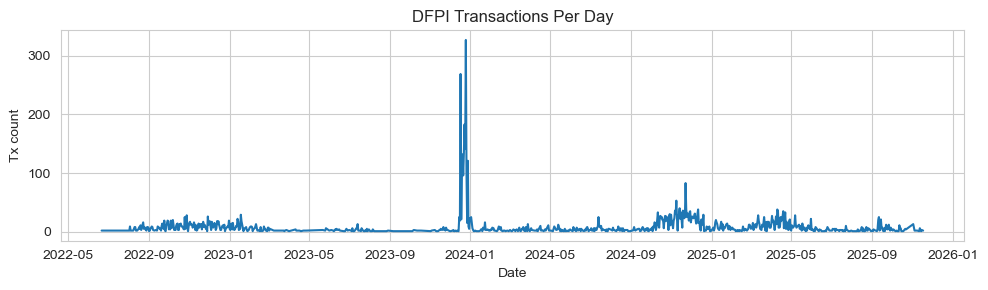

In [3]:
util.print_heading("DFPI Wallet Labels — Positives and Candidate Negatives")

# Load scam addresses (DFPI positives)
with open(SCAM_PATH) as f:
    scam_addrs = [line.strip() for line in f if line.strip()]
scam_set = {a.lower() for a in scam_addrs}

# All addresses that show up in the DFPI txs
all_addrs = pd.unique(
    pd.concat([df["from_address"], df["to_address"]], ignore_index=True)
)
all_addrs = [a for a in all_addrs if isinstance(a, str)]

# Remove the scam addresses → candidate negatives
neg_candidates = [a for a in all_addrs if a.lower() not in scam_set]

print(f"DFPI scam wallet count (file): {len(scam_addrs):,}")
print(f"Unique addresses seen in DFPI txs: {len(all_addrs):,}")
print(f"Candidate negatives (non-DFPI addresses): {len(neg_candidates):,}")

# ------------------------------------------------------------
# Sample DFPI negatives and build address-level labels
# ------------------------------------------------------------
rng = np.random.default_rng(42)

n_pos = len(scam_addrs)
target_neg_multiplier = 5           # e.g. 5x more negatives than positives
n_neg = min(len(neg_candidates), target_neg_multiplier * n_pos)

neg_sample = rng.choice(neg_candidates, size=n_neg, replace=False)

df_scam = pd.DataFrame({"Address": scam_addrs, "Scam": 1})
df_clean = pd.DataFrame({"Address": neg_sample, "Scam": 0})

addr_labels_dfpi = pd.concat([df_scam, df_clean], ignore_index=True)

print("\nDFPI label table (before pruning to present addresses):")
print(addr_labels_dfpi["Scam"].value_counts())

# Restrict labels to addresses actually present in DFPI txs
present_addrs = set(df["from_address"]) | set(df["to_address"])
addr_labels_dfpi = addr_labels_dfpi[addr_labels_dfpi["Address"].isin(present_addrs)]
addr_labels_dfpi.reset_index(drop=True, inplace=True)

print("\nDFPI label table (after restricting to present addresses):")
print(addr_labels_dfpi["Scam"].value_counts())
print("Total DFPI-labeled addresses used:", len(addr_labels_dfpi))

# ------------------------------------------------------------
# Time window and daily volume of DFPI scrape
# ------------------------------------------------------------
util.print_sub_heading("Timestamp coverage (DFPI txs)")
print("Min block_timestamp_dt:", df["block_timestamp_dt"].min())
print("Max block_timestamp_dt:", df["block_timestamp_dt"].max())

util.print_sub_heading("Daily DFPI transaction volume")

daily_dfpi = df.groupby(df["block_timestamp_dt"].dt.date).size()

plt.figure(figsize=(10, 3))
plt.plot(daily_dfpi.index, daily_dfpi.values)
plt.title("DFPI Transactions Per Day")
plt.xlabel("Date")
plt.ylabel("Tx count")
plt.tight_layout()
plt.show()

## 5. DFPI Address-Level Features

Now we push the DFPI transactions through the **same feature engineering pipeline** as the core experiment:

- Use the DFPI transaction table `df` as `transaction_df`.
- Target the **union of DFPI scam wallets + sampled neighbors** as `target_addresses`.
- Define `global_start` from the DFPI `block_timestamp_dt` column.
- Call `engineer_address_features` with `split_label="DFPI External"` so the logs stay readable.

The result is a `features_dfpi` table with **the same feature set** as in the random-split experiment, plus the `Scam` label column aligned to DFPI.

In [4]:
target_addresses = addr_labels_dfpi["Address"].tolist()
global_start = df["block_timestamp_dt"].min()

features_dfpi = engineer_address_features(
    transaction_df=df,
    target_addresses=target_addresses,
    addr_labels=addr_labels_dfpi,
    global_start=global_start,
    split_label="DFPI External",
)

print("Total addresses in this split:", len(features_dfpi))
print("Total scam labels:", int(features_dfpi["Scam"].sum()))
display(features_dfpi.head())


Preparing Transaction Data for Feature Engineering — DFPI External

Initial row count: 8106

----------------------------------------
Numeric Column Diagnostics
----------------------------------------

value: invalid=0
gas: invalid=0
gas_price: invalid=0
Numeric cleaning complete. Rows retained: 8106

----------------------------------------
Advanced Temporal Behavior Features
----------------------------------------



/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:427: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  time_metrics = long_advanced.groupby("Address").apply(_compute_time_metrics)
/Users/timnevits/Projects/PythonEnv311/flatiron/project-ethereum/src/featureeng.py:440: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  burstiness = long_advanced.groupby("Address").apply(burst)



----------------------------------------
Gas-Based Features
----------------------------------------


Aligning Features to Target Address List


----------------------------------------
Final Feature Table Sample — DFPI External
----------------------------------------



,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
0x9af6b373b09160ebdaf7d915f37443ef3513cfac,2,0,2,0,2,2.448280e+15,4.896561e+15,3.000000e+15,1.896561e+15,0.000000e+00,...,1.000000,2,0,93225903.0,0.000001,3.000000,14330736.0,2.444853e+09,21000.000000,1
0x171dd048d1e9fa8ed2e005b7c46ff8ac76e96047,435,466,170,45,901,5.953745e+18,2.488666e+21,6.680000e+20,1.000000e+00,4.673709e+19,...,4.468027,435,466,107556639.0,0.000024,0.933619,0.0,4.193120e+09,37306.775805,1
0x61876fa5cca2fa1a6b05764897f4aa77396c3ff7,9,7,5,3,16,2.712873e+17,2.441586e+18,2.436866e+18,1.000000e+08,3.554396e+18,...,2.852217,9,7,96941823.0,0.000003,1.250000,10614816.0,4.394525e+09,28225.625000,1
0x243bde8dd82635ea121bf56368de399546f6dafd,59,116,21,21,175,1.595334e+18,9.412469e+19,1.245439e+19,1.000000e+12,1.674250e+18,...,3.934429,59,116,91222755.0,0.000004,0.512821,16333884.0,9.901930e+09,40994.982857,1
0x6fca9545581b5b4d9383e71a2eafdbe987cfe86a,9,8,6,4,17,1.089025e+18,9.801223e+18,2.539354e+18,1.000000e+12,1.960086e+18,...,2.777777,9,8,91949583.0,0.000003,1.111111,15607056.0,2.209178e+09,47516.705882,1


Total addresses in this split: 311
Total scam labels: 16
Total addresses in this split: 311
Total scam labels: 16


,in_degree,out_degree,unique_in_degree,unique_out_degree,Tx count,Avg amount incoming,Total amount incoming,Max amount incoming,Min amount incoming,Avg amount outgoing,...,Hour entropy,Incoming count,Outgoing count,Last seen,Activity Density,In/Out Ratio,Recency,Avg gas price,Avg gas limit,Scam
0x9af6b373b09160ebdaf7d915f37443ef3513cfac,2,0,2,0,2,2.448280e+15,4.896561e+15,3.000000e+15,1.896561e+15,0.000000e+00,...,1.000000,2,0,93225903.0,0.000001,3.000000,14330736.0,2.444853e+09,21000.000000,1
0x171dd048d1e9fa8ed2e005b7c46ff8ac76e96047,435,466,170,45,901,5.953745e+18,2.488666e+21,6.680000e+20,1.000000e+00,4.673709e+19,...,4.468027,435,466,107556639.0,0.000024,0.933619,0.0,4.193120e+09,37306.775805,1
0x61876fa5cca2fa1a6b05764897f4aa77396c3ff7,9,7,5,3,16,2.712873e+17,2.441586e+18,2.436866e+18,1.000000e+08,3.554396e+18,...,2.852217,9,7,96941823.0,0.000003,1.250000,10614816.0,4.394525e+09,28225.625000,1
0x243bde8dd82635ea121bf56368de399546f6dafd,59,116,21,21,175,1.595334e+18,9.412469e+19,1.245439e+19,1.000000e+12,1.674250e+18,...,3.934429,59,116,91222755.0,0.000004,0.512821,16333884.0,9.901930e+09,40994.982857,1
0x6fca9545581b5b4d9383e71a2eafdbe987cfe86a,9,8,6,4,17,1.089025e+18,9.801223e+18,2.539354e+18,1.000000e+12,1.960086e+18,...,2.777777,9,8,91949583.0,0.000003,1.111111,15607056.0,2.209178e+09,47516.705882,1


## 6. DFPI Address-Level Feature Overview

With address-level features in hand, we want a quick read on:

- **How big this external slice is** (number of addresses, scam rate)
- **Whether DFPI scams look behaviorally different** from their local neighbors in terms of:
  - Transaction volume (`Tx count`)
  - Total value moved (incoming / outgoing)
  - Flow shape (**In/Out Ratio**)
  - Temporal footprint (**Activity Density**, **Recency**)

To keep things readable, we rescale value features from **wei → ETH** and summarize key numeric fields by `Scam` label, then plot how `Tx count` is distributed for DFPI scam vs non-scam addresses.


DFPI External — Address-Level Feature Overview


----------------------------------------
Address-level shape and scam rate
----------------------------------------

Total addresses in DFPI features: 311

Scam labels (value counts):
Scam
0    295
1     16
Name: count, dtype: int64

Scam rate: 0.05144694533762058

----------------------------------------
Key numeric feature summary (by Scam label, ETH-scaled)
----------------------------------------



Tx count                         Total incoming (ETH)                     \
        count   mean median min   max                count   mean median  min   
Scam                                                                            
0         295   7.89   1.00   1  1252                  295   9.09   0.00 0.00   
1          16 122.44  27.00   2   901                   16 233.18   9.73 0.00   

               ... Activity Density                       Recency  \
          max  ...            count mean median  min  max   count   
Scam           ...                                                  
0    2,196.21  ...              295 0.58   1.00 0.00 1.00     295   
1    2,488.67  ...               16 0.00   0.00 0.00 0.00      16   

                                                           
              mean        median       min            max  
Scam                                                       
0    48,485,260.10 52,618,248.00 16,152.00 103,212,895.00  
1    24,999,594.75 15,970,470.00      0.00  75,841,452.00  

[2 rows x 30 columns]


----------------------------------------
Tx count distribution — DFPI Scam vs Non-Scam
----------------------------------------



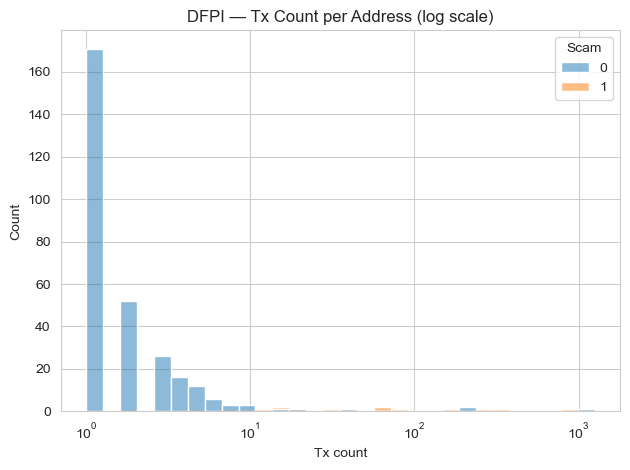

In [5]:
util.print_heading("DFPI External — Address-Level Feature Overview")

util.print_sub_heading("Address-level shape and scam rate")
print("Total addresses in DFPI features:", len(features_dfpi))
print("\nScam labels (value counts):")
print(features_dfpi["Scam"].value_counts())
print("\nScam rate:", features_dfpi["Scam"].mean())

# ---------- Rescale wei → ETH and build readable summary ----------
util.print_sub_heading("Key numeric feature summary (by Scam label, ETH-scaled)")

df_summary = features_dfpi.copy()

# Convert wei to ETH for readability
df_summary["Total incoming (ETH)"] = df_summary["Total amount incoming"] / 1e18
df_summary["Total outgoing (ETH)"] = df_summary["Total amount outgoing"] / 1e18

use_cols = [
    "Tx count",
    "Total incoming (ETH)",
    "Total outgoing (ETH)",
    "In/Out Ratio",
    "Activity Density",
    "Recency",
]

summary = df_summary.groupby("Scam")[use_cols].agg(
    ["count", "mean", "median", "min", "max"]
)

with pd.option_context("display.float_format", "{:,.2f}".format):
    display(summary)

# ---------- Plot Tx count distribution ----------
util.print_sub_heading("Tx count distribution — DFPI Scam vs Non-Scam")

sns.histplot(
    data=features_dfpi,
    x="Tx count",
    hue="Scam",
    bins=30,
    log_scale=True,
    multiple="layer",
)
plt.title("DFPI — Tx Count per Address (log scale)")
plt.tight_layout()
plt.show()

### Address-Level Behavior in the DFPI Slice

From the feature table:

- We have **311 addresses**, of which **16 (~5%)** are DFPI-flagged scams and **295 (~95%)** are local neighbors / counterparties.
- Scam wallets are **much more active**:
  - Median `Tx count`: **1** (non-scam) vs **27** (scam).
  - Mean `Tx count`: **≈8** (non-scam) vs **≈122** (scam), with some scam wallets above **900** transactions.
- Scam wallets also move far more value:
  - Median **total incoming ETH**: **0** (non-scam) vs **≈9.7 ETH** (scam).
  - Mean incoming volume: **≈9 ETH** → **≈233 ETH**, with scam maxima above **2,000 ETH**.
- Recency differs as well:
  - Non-scam addresses skew **older** (median recency ≈ **52M seconds**),
  - Scam wallets are **more recently active on average** (mean recency ≈ **25M seconds**).

The Tx-count histogram backs this up visually:

- Most **non-scam** addresses sit in the **1–5 transaction** range and then die off quickly.
- The **scam** curve shows up in the **mid- and high-count tail** instead — where you’d expect concentrated scam operations and funnels to live.

**Takeaway:** even in this small DFPI slice, scam wallets look like **high-throughput, high-volume hubs** surrounded by mostly quiet neighbors, consistent with what the random-split model was trained to pick up.

## 7. External Evaluation — Random-Split Model on DFPI Wallets

In [6]:
# Load bundle (model + feature_cols) from the random-split experiment
bundle = joblib.load("models/best_random_split_model.pkl")
model = bundle["model"]
feature_cols = bundle["feature_cols"]

# Sanity check: make sure DFPI has all the needed columns
missing = [c for c in feature_cols if c not in features_dfpi.columns]
extra   = [c for c in features_dfpi.columns if c not in feature_cols and c != "Scam"]

print("Missing feature columns in DFPI:", missing)
print("Extra columns in DFPI:", extra)

# If there are missing features, restrict to the intersection
if missing:
    feature_cols = [c for c in feature_cols if c in features_dfpi.columns]
    print("Using reduced feature_cols:", feature_cols)

X_ext = features_dfpi[feature_cols].values
y_ext = features_dfpi["Scam"].values

y_ext_prob = model.predict_proba(X_ext)[:, 1]
y_ext_pred = (y_ext_prob >= 0.5).astype(int)

print("DFPI External ROC AUC:", roc_auc_score(y_ext, y_ext_prob))
print("DFPI External AP:", average_precision_score(y_ext, y_ext_prob))
print("Confusion:\n", confusion_matrix(y_ext, y_ext_pred))

Missing feature columns in DFPI: []
Extra columns in DFPI: []
DFPI External ROC AUC: 0.9671610169491525
DFPI External AP: 0.8959011627906976
Confusion:
 [[292   3]
 [  2  14]]


### External Evaluation Takeaways

Using the **tuned XGBoost model from the random address split**, we score the DFPI wallets as-is (same feature set, same threshold = 0.5):

- **ROC AUC:** ~0.97  
- **Average Precision:** ~0.90  
- **Confusion matrix (DFPI, threshold 0.5):**

  - True negatives: 292  
  - False positives: 3  
  - False negatives: 2  
  - True positives: 14  

Interpreting this:

- The model **still ranks wallets very well** in this new slice of the chain (ROC AUC close to 1.0), even though DFPI covers **only late-2024 scams** and a small neighborhood of counterparties.
- With a base rate of ~5% scams in this DFPI set, an **AP of ~0.90** means the model can concentrate most of the scam wallets near the top of the score distribution.
- At the default 0.5 threshold, it:
  - Flags **17 wallets total**,  
  - Gets **14 of them right** (precision ≈ 0.82),  
  - Misses **2 out of 16 scams** (recall ≈ 0.88).

So the random-split model, which was trained on a **stitched, historical sample** with a tiny scam rate, **generalizes strongly** to this **independent, 2024-only regulator list**. It doesn’t just memorize our original dataset; it picks out high-risk behavior in a fresh, real-world slice of the chain.

## 8. Summary — DFPI External Evaluation

This notebook answers a different question from the random-split and time-split experiments:

> **Does the model trained on our stitched historical dataset still detect scams in a fresh,
> regulator-curated slice of the chain?**

Key points:

- The DFPI external dataset contains **311 addresses**, of which **16 (~5%)** are labeled as DFPI-reported scam wallets.
- Activity is concentrated in **late 2024**, so this is a **recent, time-local** view rather than a historical sample spread over many years.
- Negatives here are **counterparties and neighbors of known scams**, not a random sample of all Ethereum addresses. This makes DFPI a *scam-adjacent* evaluation set, not a clean population survey.
- When we apply the **tuned random-split XGBoost model** (same features, default threshold 0.5), performance on DFPI is strong: ROC AUC ≈ 0.97, AP ≈ 0.90, precision ≈ 0.82, recall ≈ 0.88.
- **Implication:** the model is not just memorizing quirks of the training sample. It carries over to an **independent 2024 regulator list**, picking out most scam wallets with a small number of false alarms.

Taken together with the random-split and time-split notebooks:

- **Random split:** “How well can we do under stable, i.i.d. conditions?”  
- **Time split:** “What happens when the future drifts away from the past?”  
- **DFPI external:** “Given that model, **can it still spot scams in a real regulator list that lives in a different time window and local neighborhood of the chain?**”